# Importation des packages

In [12]:
import os

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd

# Préparation des données 

In [13]:
IMAGE_SIZE=128
BATCH_SIZE = 128
FOLDER = "Donnee_DP_réduite"
# create generator
datagen = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)

# prepare an iterators for each dataset
train = datagen.flow_from_directory(os.path.join(FOLDER,'train'), target_size=(IMAGE_SIZE, IMAGE_SIZE), class_mode="sparse", color_mode="rgb", batch_size=BATCH_SIZE)
val = datagen_val.flow_from_directory(os.path.join(FOLDER,'val'), target_size=(IMAGE_SIZE, IMAGE_SIZE), class_mode="sparse",color_mode="rgb", batch_size=BATCH_SIZE)
# confirm the iterator works
batchX, batchy = train.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 2291 images belonging to 2 classes.
Found 285 images belonging to 2 classes.
Batch shape=(128, 128, 128, 3), min=0.000, max=1.000


### NOMBRE DE CLASSE 

In [15]:
NUM_CLASSES=2

# Construction du réseau ResNet50
Possibilitée de changer les hyperparamètres dans la compilation du modèle

In [17]:
from tensorflow.keras.applications import ResNet50

In [18]:
def build_resnet():
    model = ResNet50(include_top=True, weights=None, classes=NUM_CLASSES)
    return model

In [19]:
model = build_resnet()

METRICS = ["accuracy"]
    
model.compile(
        optimizer='adam',
        loss= tf.losses.SparseCategoricalCrossentropy(),
        metrics=METRICS
)

In [20]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

# Learning Rate Schedules et sauvegarde du modéle

Les learning rate schedules visent à ajuster le taux d'apprentissage pendant la formation en réduisant le taux d'apprentissage selon un schedule prédéfini.

In [21]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(FOLDER+"_model_sans_DA_Conta_Autre.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)

# Entrainement du modèle

In [22]:
history = model.fit(
    train,
    validation_data=val,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=100
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 18 steps, validate for 3 steps
Epoch 1/100
18/18 [==============================] - 33s 2s/step - loss: 3.3052 - accuracy: 0.5024 - val_loss: 14575853418927446.0000 - val_accuracy: 0.4421
Epoch 2/100
18/18 [==============================] - 23s 1s/step - loss: 1.1510 - accuracy: 0.5639 - val_loss: 321534405290.6667 - val_accuracy: 0.4421
Epoch 3/100
18/18 [==============================] - 23s 1s/step - loss: 0.8789 - accuracy: 0.5648 - val_loss: 312458432.0000 - val_accuracy: 0.4421
Epoch 4/100
18/18 [==============================] - 24s 1s/step - loss: 0.8125 - accuracy: 0.5744 - val_loss: 453828.3021 - val_accuracy: 0.4421
Epoch 5/100
18/18 [==============================] - 24s 1s/step - loss: 0.7468 - accuracy: 0.5775 - val_loss: 36.8723 - val_accuracy: 0.4632
Epoch 6/100
18/18 [==============================] - 23s 1s/step - loss: 0.7004 - accuracy: 0.6024 - val_loss: 0.7881 - val_accuracy: 0.5544
Epoch 7/100
18/18 [===

# Affichage des résultats pour images d'entrainement et de validation

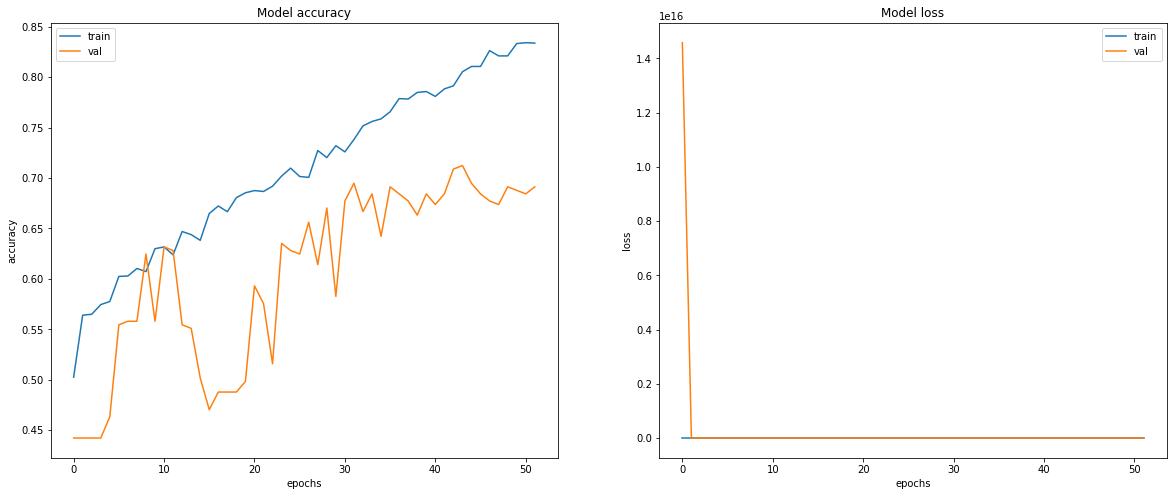

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Préparation des images de test

In [24]:
datagen_test = ImageDataGenerator(rescale=1./255)

test = datagen.flow_from_directory(os.path.join(FOLDER,'test'), target_size=(IMAGE_SIZE, IMAGE_SIZE), class_mode="sparse",color_mode="rgb", batch_size=BATCH_SIZE)

Found 287 images belonging to 2 classes.


# Chargement du modèle construit 

In [25]:
model_sans_DA = tf.keras.models.load_model("Donnee_DP_model_sans_DA_Conta_Autre.h5")

# Evaluation du modèle à l'aide des données test

In [26]:
_ = model_sans_DA.evaluate(test)

  ...
    to  
  ['...']
3/3 [==============================] - 4s 1s/step - loss: 0.7677 - accuracy: 0.5575
